### Считывание кластеризованных данных

In [2]:
import os
import pandas as pd

os.chdir('../../../')

In [10]:
df = pd.read_csv('data/lmsys-chat-1m/processed/kmeans_clusters.csv')
df.head()

,user_id,neutral_count,positive_count,negative_count,total_reformulations,total_words,total_spelling_errors,total_questions,cluster
0,0,0.000000,1.0,0.000000,0.0,11.0,0.0,0.000000,1
1,1,0.333333,0.5,0.166667,0.5,25.0,0.5,0.666667,1
2,2,0.000000,1.0,0.000000,0.0,66.0,0.0,0.000000,1
3,3,0.500000,0.5,0.000000,0.0,14.5,0.0,0.000000,0
4,4,1.000000,0.0,0.000000,0.0,18.0,3.0,0.000000,0


### Обучение классификатора

In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
from scipy.stats import randint, uniform
import time

X = df.drop(['user_id', 'cluster'], axis=1)
y = df['cluster']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_dist_xgb = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 1),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

model_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

search_xgb = RandomizedSearchCV(
    model_xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

start = time.time()
search_xgb.fit(X_train, y_train)
end = time.time()


print(f"XGBoost — лучшая модель: {search_xgb.best_params_}")
print(f"Время подбора: {round(end - start, 2)} сек")

best_model = search_xgb.best_estimator_
y_pred = best_model.predict(X_test)

print("Качество (XGBoost):")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\hqdem\PythonProjects\user-pattern-analysis\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:00:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost — лучшая модель: {'colsample_bytree': np.float64(0.7334834444556088), 'gamma': np.float64(0.14286681792194078), 'learning_rate': np.float64(0.14017769458977059), 'max_depth': 7, 'n_estimators': 357, 'reg_alpha': np.float64(0.7219987722668247), 'reg_lambda': np.float64(0.9385527090157502), 'subsample': np.float64(0.6003115063364057)}
Время подбора: 108.77 сек
Качество (XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11437
           1       1.00      1.00      1.00      8523
           2       1.00      0.99      0.99       324
           3       0.99      0.99      0.99      2065
           4       1.00      1.00      1.00      3351
           5       0.98      0.97      0.97       233

    accuracy                           1.00     25933
   macro avg       0.99      0.99      0.99     25933
weighted avg       1.00      1.00      1.00     25933



### Проверка на переобучение

In [12]:
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")

Train accuracy: 0.9993
Test accuracy:  0.9977


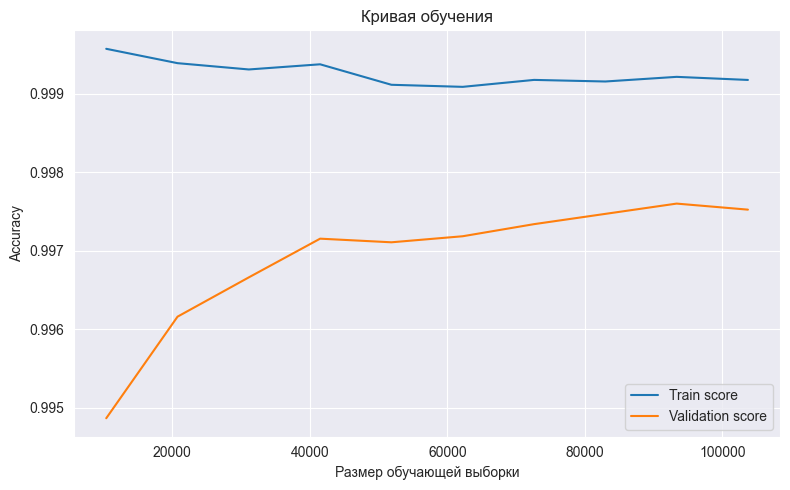

In [13]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Train score')
plt.plot(train_sizes, test_mean, label='Validation score')
plt.xlabel("Размер обучающей выборки")
plt.ylabel("Accuracy")
plt.title("Кривая обучения")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Сохраняем модель

In [14]:
import joblib

joblib.dump(best_model, 'models/gradient_boosting/model_xgboost.pkl')

['models/gradient_boosting/model_xgboost.pkl']

### Проверка без дубликатов

In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
from scipy.stats import randint, uniform
import time

X = df.drop(['user_id', 'cluster'], axis=1)
y = df['cluster']
X = X.drop_duplicates()
y = y.loc[X.index]  # пересинхронизация y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_dist_xgb = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 1),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

model_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

search_xgb = RandomizedSearchCV(
    model_xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

start = time.time()
search_xgb.fit(X_train, y_train)
end = time.time()

print(f"XGBoost — лучшая модель: {search_xgb.best_params_}")
print(f"Время подбора: {round(end - start, 2)} сек")

best_model = search_xgb.best_estimator_
y_pred = best_model.predict(X_test)

print("Качество (XGBoost):")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\hqdem\PythonProjects\user-pattern-analysis\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:02:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost — лучшая модель: {'colsample_bytree': np.float64(0.7168578594140873), 'gamma': np.float64(0.3663618432936917), 'learning_rate': np.float64(0.10121399684340719), 'max_depth': 5, 'n_estimators': 463, 'reg_alpha': np.float64(0.5142344384136116), 'reg_lambda': np.float64(0.5924145688620425), 'subsample': np.float64(0.6185801650879991)}
Время подбора: 35.57 сек
Качество (XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3096
           1       0.99      0.99      0.99      1936
           2       0.98      0.99      0.98       252
           3       0.99      0.98      0.99      1211
           4       0.99      0.99      0.99      1195
           5       0.98      0.99      0.99       208

    accuracy                           0.99      7898
   macro avg       0.99      0.99      0.99      7898
weighted avg       0.99      0.99      0.99      7898



### Проверка на переобучение

In [16]:
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")

Train accuracy: 0.9982
Test accuracy:  0.9929


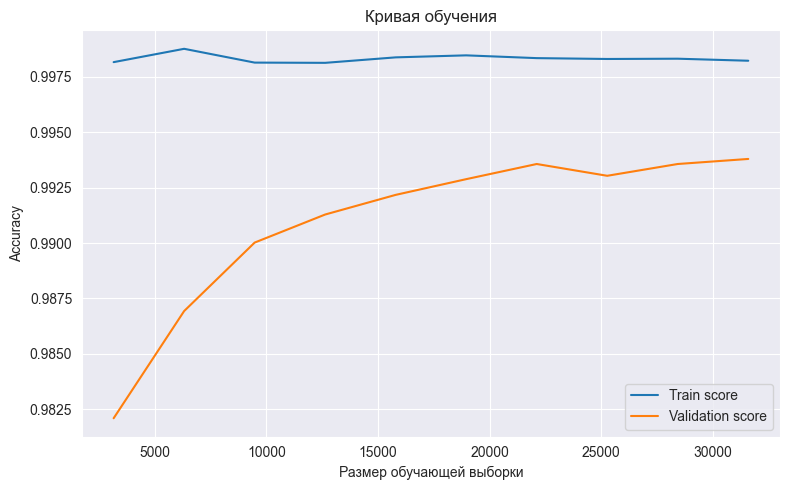

In [17]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Train score')
plt.plot(train_sizes, test_mean, label='Validation score')
plt.xlabel("Размер обучающей выборки")
plt.ylabel("Accuracy")
plt.title("Кривая обучения")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Сохраняем модель

In [18]:
import joblib

joblib.dump(best_model, 'models/gradient_boosting/model_xgboost_wo_duplicates.pkl')

['models/gradient_boosting/model_xgboost_wo_duplicates.pkl']